## <font color = 'purple'>Notebook 5: Naive Bayes</font>

<font color = 'purple'>Naive Bayes is a probabilistic machine learning algorithm based on Bayes' Theorem, which assumes that the features of a dataset are independent of each other (hence the term "naive"). It is particularly useful for classification tasks, such as text classification or spam detection, as it calculates the probability of a class given a set of features and predicts the class with the highest probability.</font>

## <font color = 'purple'>Import packages</font>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving main_dataset.xlsx to main_dataset.xlsx


In [ ]:
# Libraries for data processing
import numpy as np
import pandas as pd

# Libraries for text processing and NLP
import nltk
from textblob import TextBlob

# Gensim library for topic modelling and text vectorisation
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess

# Libraries for data visualisation
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous imports
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#pip install --upgrade numexpr bottleneck

In [ ]:
# Verifying installation of dependencies
import numexpr
import bottleneck

print("NumExpr version:", numexpr.__version__)
print("Bottleneck version:", bottleneck.__version__)

NumExpr version: 2.10.1
Bottleneck version: 1.4.0


## <font color = 'purple'>Load data</font>
<font color = 'purple'>Note: Due to a TrueType fonts error appearing during WordCloud process, which occurred due to the combined_reviews.csv file containing a different font, this had to be changed to Arial for the error to be diminished.</font>

In [ ]:
df = pd.read_excel('main_dataset.xlsx')

print("Shape of the dataset:", df.shape)
print("Columns in the dataset:", df.columns)

df.head()

Shape of the dataset: (44855, 4)
Columns in the dataset: Index(['date', 'review', 'rating', 'userName'], dtype='object')


,date,review,rating,userName
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286


In [ ]:
#pip install --upgrade openpyxl

In [ ]:
import openpyxl
print(openpyxl.__version__)

3.1.5


### <font color = 'purple'>Data Pre-processing</font>



<font color = 'purple'>
The below code defines a `preprocess_text` function to clean and standardise text by converting it to lowercase, removing punctuation, digits, and extra spaces. It applies this function to the 'content' column of a DataFrame, creating a new column `content_cleaned` with the processed text.
</font>

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download stopwords if you haven't already
nltk.download('stopwords')

# Set of stopwords in English
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isna(text) or not isinstance(text, str):
        return ""

    # Convert text to lowercase
    text = text.lower()

    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # Split text into words and remove stopwords
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]

    # Join the filtered words back into a single string
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

df['content_cleaned'] = df['review'].apply(preprocess_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,date,review,rating,userName,content_cleaned
0,2021-05-06 05:15:00.000,This feature has been one of the most annoying...,5,Keanu De Sousa,feature one annoying aspects whatsapp everytim...
1,2024-02-01 09:06:59.904,"The privacy on WhatsApp is incredible, I know ...",4,The great idea!!!,privacy whatsapp incredible know probably donä...
2,2023-08-14 05:42:00.000,"Hi WhatsApp,\nThis app is really great, I use ...",4,Pokey Ball ‚öæÔ∏è,hi whatsapp app really great use everyday exac...
3,2024-08-04 15:53:00.384,If there was ever an equivalent of social serv...,1,Zenicero,ever equivalent social services took words awa...
4,2024-05-26 01:12:59.616,Im on holiday and reliant on whatsapp to commu...,1,JohnDoe63737286,im holiday reliant whatsapp communicate agents...


In [ ]:
df.isnull()
total_null_values = df.isnull().sum().sum()
print("Total null values in the DataFrame: ", total_null_values)

Total null values in the DataFrame:  12


In [ ]:
df.fillna('', inplace = True)

In [ ]:
df['date'] = pd.to_datetime(df['date'], dayfirst = True)

In [ ]:
df = df[['content_cleaned', 'review', 'rating', 'date']]
df.head()

,content_cleaned,review,rating,date
0,feature one annoying aspects whatsapp everytim...,This feature has been one of the most annoying...,5,2021-05-06 05:15:00.000
1,privacy whatsapp incredible know probably donä...,"The privacy on WhatsApp is incredible, I know ...",4,2024-02-01 09:06:59.904
2,hi whatsapp app really great use everyday exac...,"Hi WhatsApp,\nThis app is really great, I use ...",4,2023-08-14 05:42:00.000
3,ever equivalent social services took words awa...,If there was ever an equivalent of social serv...,1,2024-08-04 15:53:00.384
4,im holiday reliant whatsapp communicate agents...,Im on holiday and reliant on whatsapp to commu...,1,2024-05-26 01:12:59.616


In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [ ]:
df['sentiment'] = df['content_cleaned'].apply(get_sentiment)
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.1 else
                                             ('negative' if x <- 0.1 else 'neutral'))

In [ ]:
df[['content_cleaned', 'rating', 'sentiment_label']]

,content_cleaned,rating,sentiment_label
0,feature one annoying aspects whatsapp everytim...,5,negative
1,privacy whatsapp incredible know probably donä...,4,positive
2,hi whatsapp app really great use everyday exac...,4,positive
3,ever equivalent social services took words awa...,1,positive
4,im holiday reliant whatsapp communicate agents...,1,negative
...,...,...,...
44850,free delivery prime,5,positive
44851,would expectamazon trying get hand pocket,3,neutral
44852,registry system mess sorting price low high wa...,2,neutral
44853,clothes furniture options kinda meh overall de...,3,neutral


### <font color = 'purple'>Naive Bayes</font>

In [ ]:
# Libraries for model building and evaluation for Naive Bayes
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000)
X = tfidf_vectorizer.fit_transform(df['content_cleaned'])
y = df['sentiment_label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)

In [ ]:
print("Multinomial Naive Bayes: ")
multinomial_nb = MultinomialNB()
evaluate_model(multinomial_nb, X_train, X_test, y_train, y_test)

Multinomial Naive Bayes: 
Accuracy: 73.26%
Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.21      0.34       708
     neutral       0.69      0.57      0.63      3331
    positive       0.74      0.92      0.82      4932

    accuracy                           0.73      8971
   macro avg       0.80      0.57      0.60      8971
weighted avg       0.74      0.73      0.71      8971

------------------------------------------------------------


In [ ]:
print("Bernoulli Naive Bayes: ")
bernoulli_nb = BernoulliNB()
evaluate_model(bernoulli_nb, X_train, X_test, y_train, y_test)

Bernoulli Naive Bayes: 
Accuracy: 77.76%
Classification Report:
              precision    recall  f1-score   support

    negative       0.26      0.57      0.36       708
     neutral       0.82      0.71      0.76      3331
    positive       0.93      0.85      0.89      4932

    accuracy                           0.78      8971
   macro avg       0.67      0.71      0.67      8971
weighted avg       0.84      0.78      0.80      8971

------------------------------------------------------------


In [ ]:
print("Gaussian Naive Bayes: ")
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

gaussian_nb = GaussianNB()
evaluate_model(gaussian_nb, X_train_dense, X_test_dense, y_train, y_test)

Gaussian Naive Bayes: 
Accuracy: 40.75%
Classification Report:
              precision    recall  f1-score   support

    negative       0.12      0.84      0.20       708
     neutral       0.70      0.27      0.39      3331
    positive       0.87      0.44      0.58      4932

    accuracy                           0.41      8971
   macro avg       0.56      0.52      0.39      8971
weighted avg       0.74      0.41      0.48      8971

------------------------------------------------------------


<font color = 'purple'>Let's now plot the Precision-Recall (PR) curves of Naive Bayes to evaluate the performance of the Naive Bayes model, especially for imbalanced classes which is common in sentiment analysis.</font>

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
ovr_nb_model = OneVsRestClassifier(MultinomialNB())
ovr_nb_model.fit(X_train, y_train)

y_score = ovr_nb_model.predict_proba(X_test)

precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(ovr_nb_model.classes_)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == ovr_nb_model.classes_[i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test == ovr_nb_model.classes_[i], y_score[:, i])

<Figure size 1000x700 with 0 Axes>

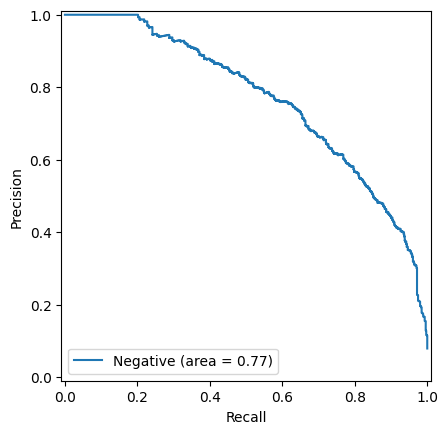

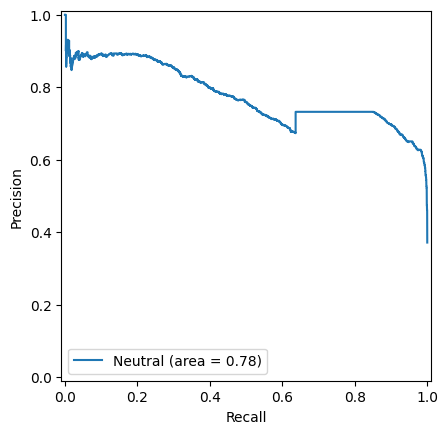

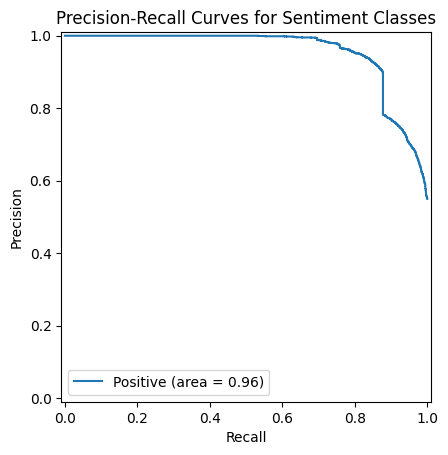

In [ ]:
plt.figure(figsize = (10, 7))

for i, label in enumerate(ovr_nb_model.classes_):
    PrecisionRecallDisplay(precision=precision[i], recall=recall[i], average_precision=average_precision[i]).plot(
        label=f'{label.capitalize()} (area = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Sentiment Classes')
plt.legend(loc="lower left")
plt.show()

In [ ]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]
}

multinomial_nb = MultinomialNB()

grid_search = GridSearchCV(multinomial_nb, param_grid, cv=5, scoring='f1_weighted', n_jobs=1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated F1 score: {best_score:.4f}")

best_nb_model = grid_search.best_estimator_

y_pred = best_nb_model.predict(X_test)
y_score = best_nb_model.predict_proba(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Best parameters: {'alpha': 0.1}
Best cross-validated F1 score: 0.7287

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.38      0.52       708
     neutral       0.71      0.58      0.64      3331
    positive       0.76      0.91      0.82      4932

    accuracy                           0.74      8971
   macro avg       0.76      0.62      0.66      8971
weighted avg       0.74      0.74      0.73      8971

Confusion Matrix:
[[ 272  353   83]
 [  49 1935 1347]
 [  13  453 4466]]
Accuracy: 0.7438
